# HW2 - Analysis 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection._search import ParameterGrid
import seaborn as sns
import copy

In [2]:
%matplotlib inline

In [5]:
from whatif import Model
from whatif import get_sim_results_df

### Base Model

This works - so there must be some reason self.demand needs () in the formula and the __init__ variables do not (in the demand and profit formulas) - 
Found online: self.demand() is called with parentheses because it's invoking a method of the class instance (self). If demand were an attribute rather than a method, you would access it without parentheses, as in self.demand.

In [148]:
class SingleProductSPF(Model):
    def __init__(self, fixed_cost=5000, var_cost=100, selling_price=0,
                 spf_constant=4900, spf_linear=-35, spf_quadratic=0.06):
        self.fixed_cost = fixed_cost
        self.var_cost = var_cost
        self.selling_price = selling_price
        self.spf_constant = spf_constant
        self.spf_linear = spf_linear
        self.spf_quadratic = spf_quadratic
        
    def demand(self):
        """Compute demand"""
        demand = (self.spf_quadratic * (self.selling_price ** 2)) + (self.spf_linear * self.selling_price) + self.spf_constant
        return demand
    
    def profit(self):
        """Compute profit"""
        profit = (self.demand() * self.selling_price) - (self.demand() * self.var_cost) - self.fixed_cost
        return profit


In [150]:
# Create a dictionary of base input values

base_inputs = {'selling_price': 115}

In [155]:
# Create a new model with default input values (0's)
model_test = SingleProductSPF()
print(model_test)
model_test.demand()

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 0, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


4900.0

In [157]:
# Update model with base inputs
model_test.update(base_inputs)
print(model_test)

{'fixed_cost': 5000, 'var_cost': 100, 'selling_price': 115, 'spf_constant': 4900, 'spf_linear': -35, 'spf_quadratic': 0.06}


In [161]:
model_test.demand()

1668.5

In [159]:
model_test.profit()

20027.5

In [164]:
def data_table(model, scenario_inputs, outputs):
    '''Create n-inputs by m-outputs data table.

    Parameters
    ----------
    model : object
        User defined object containing the appropriate methods and properties for computing outputs from inputs
    scenario_inputs : dict of str to sequence
        Keys are input variable names and values are sequence of values for each scenario for this variable. Is consumed by
        scikit-learn ParameterGrid() function. See https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
    outputs : list of str
        List of output variable names

    Returns
    -------
    results_df : pandas DataFrame
        Contains values of all outputs for every combination of scenario inputs
    '''
    
    # Clone the model using deepcopy
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(scenario_inputs))
    
    # Create the table as a list of dictionaries
    results = []

    # Loop over the scenarios
    for params in dt_param_grid:
        # Update the model clone with scenario specific values
        model_clone.update(params)
        # Create a result dictionary based on a copy of the scenario inputs
        result = copy.copy(params)
        # Loop over the list of requested outputs
        for output in outputs:
            # Compute the output.
            out_val = getattr(model_clone, output)()
            # Add the output to the result dictionary
            result[output] = out_val
        
        # Append the result dictionary to the results list
        results.append(result)

    # Convert the results list (of dictionaries) to a pandas DataFrame and return it
    results_df = pd.DataFrame(results)
    return results_df

In [170]:
# Specify input ranges for scenarios (dictionary)
dt_param_ranges = {'selling_price': np.arange(80, 141, 10)}

# Specify desired outputs (list)
outputs = ['profit', 'demand']

# Use data_table function
mt_dt1_df = data_table(model_test, dt_param_ranges, outputs)
mt_dt1_df

,selling_price,profit,demand
0,80,-54680.0,2484.0
1,90,-27360.0,2236.0
2,100,-5000.0,2000.0
3,110,12760.0,1776.0
4,120,26280.0,1564.0
5,130,35920.0,1364.0
6,140,42040.0,1176.0


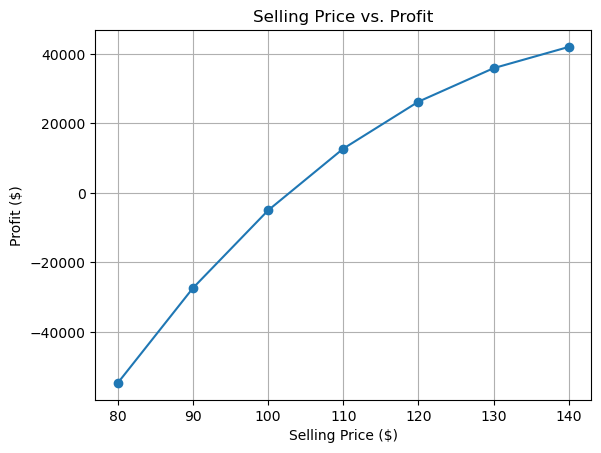

In [178]:
# Plot
plt.plot(mt_dt1_df['selling_price'], mt_dt1_df['profit'], marker='o')

# Labeling the plot
plt.title('Selling Price vs. Profit')
plt.xlabel('Selling Price ($)')
plt.ylabel('Profit ($)')

# Show plot
plt.grid(True)
plt.show()

It is non-linear with a curve, as the demand formula is quadratic